In [1]:
%matplotlib inline

https://indico.cern.ch/event/628669/contributions/2600995/attachments/1463252/2266733/2017_05_26_Hmm_preApproval.pdf

In [2]:
import uproot, cupy, awkward
from awkward.util import numpy as anp
import numpy as np
import dask
import glob
import psutil, os
from collections import OrderedDict
from typing import List, Dict
import math
import numba
import time
from concurrent.futures import ThreadPoolExecutor

#need to set these explicitly
os.environ["NUMBAPRO_NVVM"] = "/usr/local/cuda-9.2/nvvm/lib64/libnvvm.so"
os.environ["NUMBAPRO_LIBDEVICE"] = "/usr/local/cuda-9.2/nvvm/libdevice/"
from numba import cuda


/usr/local/lib/python3.5/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
!nvidia-smi

Mon Mar 25 17:27:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.26                 Driver Version: 396.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:07:00.0 Off |                  N/A |
| 22%   51C    P2    74W / 250W |    243MiB / 12210MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
awkward.__version__, cupy.__version__

('0.8.11', '6.0.0a1')

In [5]:
import matplotlib.pyplot as plt

In [6]:
#[jpata@login-1 ~]$ rsync -r -R --progress /mnt/hadoop/store/./data/Run2017*/SingleMuon/NANOAOD/Nano14Dec2018-v1 titans.hep.caltech.edu:/nvmedata/store/
files = OrderedDict()
files["dy"] = glob.glob("/nvmedata/store/mc/RunIIFall17NanoAOD/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/**/*.root", recursive=True)
files["ggh"] = glob.glob("/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/**/*.root", recursive=True)

files["data_2017"] = glob.glob("/nvmedata/store/data/Run2017*/SingleMuon/NANOAOD/Nano14Dec2018-v1/**/*.root")

In [7]:
#remove the friend trees
files["ggh"] = [x for x in files["ggh"] if "Friend" not in x]

In [8]:
files["ggh"]

['/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/76434428-F342-E811-8E45-B499BAAC3786.root',
 '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/0C2B3A66-B042-E811-8C6D-44A8423DE2C0.root',
 '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/E07AC933-F342-E811-A68D-3417EBE5354A.root']

In [9]:
for k, v in files.items():
    print(k, len(v))

dy 154
ggh 3
data_2017 240


In [72]:
arrays_ev = [
    "PV_npvsGood", "Flag_METFilters", "Flag_goodVertices", "Generator_weight", "genWeight", "HLT_IsoMu24"
]
arrays_jet = [
    "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagDeepB", "Jet_jetId"
]

arrays_muon = [
    "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_pfRelIso03_all", "Muon_mediumId", "Muon_charge"
]

arrays_to_load = arrays_jet + arrays_muon

In [11]:
arrays_gen = [
    "GenPart_pt", "GenPart_eta", "GenPart_phi", "GenPart_mass", "GenPart_pdgId", "GenPart_status"
]

In [12]:
fn = files["dy"][0]
fi = uproot.open(fn)
tt = fi.get("Events")

In [44]:
"""
Preloads all data into memory.

Args:
    dataset_files (Dict[str, List[str]]): a dictionary of dataset name to the list of filenames for each dataset

returns:
    Dict[str, List[Dict[str, JaggedArray]]]
    
    For each dataset, a list of awkward-array JaggedArray dictionaries 
"""
def preload_data(dataset_files, arrays_to_load):
    ret = {}
    for dsname, dsfiles in dataset_files.items():
        ret[dsname] = [load_arrays(fn, arrays_to_load) for fn in dsfiles]
    return ret

def load_arrays(fn, arrays_to_load):
    #print("opening file {0}".format(fn))
    fi = uproot.open(fn)
    tt = fi.get("Events")
    with ThreadPoolExecutor(max_workers=16) as executor:
        arrs = tt.arrays(arrays_to_load, executor=executor)
    #print("loaded {0} arrays, shape=({1},)".format(len(arrs), tt.numentries))
    return arrs

In [45]:
def get_mem():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss/1024.0/1024.0/1024.0

In [46]:
def print_mem():
    print("Using {0:.2f} GB of RSS".format(get_mem()))

In [47]:
print_mem()
t0 = time.time()
preloaded_data = preload_data({
    "dy": files["dy"][:10],
     "ggh": files["ggh"][:10],
    "data_2017": files["data_2017"][:10]
    }, arrays_to_load)
print_mem()
t1 = time.time()
dt = t1 - t0

sum_ev = 0
for k in preloaded_data.keys():
    for arrs in preloaded_data[k]:
        sum_ev += len(arrs[b"Jet_pt"])
print("Loaded {0:.2E} events in {1:.0f} seconds, speed {2:.2E} Hz".format(sum_ev, dt, sum_ev/dt))

Using 14.16 GB of RSS
Using 18.49 GB of RSS
Loaded 4.12E+07 events in 70 seconds, speed 5.86E+05 Hz


In [17]:
def midpoints(arr):
    return arr[:-1]# - np.diff(arr)

In [18]:
def compute_inv_mass(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    
    px_total = px.sum()
    py_total = py.sum()
    pz_total = pz.sum()
    mass_total = mass.sum()
    
    inv_mass = np.sqrt(px_total**2 + py_total**2 + pz_total**2 - mass_total**2)
    return inv_mass

In [19]:
def compute_inv_mass_gen(arrs):
    genmu = ((anp.abs(arrs[b"GenPart_pdgId"])) == 13) & (arrs[b"GenPart_status"]==1)
    inv_mass_gen = compute_inv_mass(
        arrs[b"GenPart_pt"][genmu][:, 0:2],
        arrs[b"GenPart_eta"][genmu][:, 0:2],
        arrs[b"GenPart_phi"][genmu][:, 0:2],
        arrs[b"GenPart_mass"][genmu][:, 0:2]
    )
    return inv_mass_gen

In [20]:
@cuda.jit(device=True)
def searchsorted(arr, val):
    ret = -1
    for i in range(len(arr)):
        if val <= arr[i]:
            ret = i
            break
    return ret

In [21]:
@cuda.jit
def fill_histogram(data, weights, bins, out_w, out_w2):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)
    
    for i in range(xi, len(data), xstride):
        bin_idx = searchsorted(bins, data[i])
        if bin_idx >=0 and bin_idx < len(out_w):
            cuda.atomic.add(out_w, bin_idx, weights[i])
            cuda.atomic.add(out_w2, bin_idx, weights[i]**2)

In [22]:
bins = cupy.linspace(-3,3,100)
N = 100000

weights = cupy.ones(N)
data = cupy.random.randn(N)
out_w = cupy.zeros(len(bins), dtype=np.float32)
out_w2 = cupy.zeros(len(bins), dtype=np.float32)

fill_histogram[32, 1024](data, weights, bins, out_w, out_w2)

In [23]:
class Histogram:
    def __init__(self, contents, contents_w2, edges):
        self.contents = cupy.asnumpy(contents)
        self.contents_w2 = cupy.asnumpy(contents_w2)
        self.edges = cupy.asnumpy(edges)
        
    @staticmethod
    def from_vector(data, weights, bins):        
        out_w = cupy.zeros(len(bins) - 1, dtype=np.float32)
        out_w2 = cupy.zeros(len(bins) - 1, dtype=np.float32)
        fill_histogram[32, 1024](data, weights, bins, out_w, out_w2)
        return Histogram(out_w, out_w2, bins)
    
    def __add__(self, other):
        assert(cupy.all(self.edges == other.edges))
        return Histogram(self.contents +  other.contents, self.edges)

    def plot(self):
        line = plt.step(self.edges[:-1], self.contents, where="mid")
        plt.errorbar(midpoints(self.edges), self.contents, np.sqrt(self.contents), lw=0, elinewidth=1, color=line[0].get_color())
    
    
def get_histogram(data, weights, bins):
    return Histogram.from_vector(data, weights, bins)


class Results(dict):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __add__(self, other):
        d0 = self
        d1 = other
        
        d_ret = Results({})
        k0 = set(d0.keys())
        k1 = set(d1.keys())

        for k in k0.intersection(k1):
            d_ret[k] = d0[k] + d1[k]

        for k in k0.difference(k1):
            d_ret[k] = d0[k]

        for k in k1.difference(k0):
            d_ret[k] = d1[k]

        return d_ret

In [58]:
class JaggedStruct(object):
    def __init__(self, offsets, attrs_data, numpy_lib=np):
        self.numpy_lib = numpy_lib
        
        self.offsets = offsets
        self.attrs_data = attrs_data
        
        num_items = None
        for (k, v) in self.attrs_data.items():
            num_items_next = len(v)
            if num_items and num_items != num_items_next:
                raise AttributeError("Mismatched attribute {0}".format(k))
            else:
                num_items = num_items_next
            setattr(self, k, v)
        self.num_items = num_items
    
        self.masks = {}
        self.masks["all"] = self.make_mask()
    
    def make_mask(self):
        return self.numpy_lib.ones(self.num_items, dtype=self.numpy_lib.bool)
    
    def mask(self, name):
        if not name in self.masks.keys():
            self.masks[name] = self.make_mask()
        return self.masks[name]
    
    def size(self):
        size_tot = self.offsets.size
        for k, v in self.attrs_data.items():
            size_tot += v.size
        return size_tot
    
    def __len__(self):
        return len(self.offsets) - 1
    
    @staticmethod
    def from_arraydict(arraydict, prefix, numpy_lib=np):
        ks = [k for k in arraydict.keys() if prefix in str(k, 'ascii')]
        k0 = ks[0]
        return JaggedStruct(
            numpy_lib.array(arraydict[k0].offsets),
            {str(k, 'ascii').replace(prefix, ""): numpy_lib.array(v.content)
             for (k,v) in arraydict.items()},
            numpy_lib=numpy_lib
        )

In [25]:
#https://github.com/CoffeaTeam/fnal-column-analysis-tools/blob/master/fnal_column_analysis_tools/lumi_tools/__init__.py
class LumiMask(object):
    """
        Class that parses a 'golden json' into an efficient valid lumiSection lookup table
        Instantiate with the json file, and call with an array of runs and lumiSections, to
        return a boolean array, where valid lumiSections are marked True
    """
    def __init__(self, jsonfile):
        with open(jsonfile) as fin:
            goldenjson = json.load(fin)
        self._masks = {}
        for run, lumilist in goldenjson.items():
            run = int(run)
            mask = np.array(lumilist).flatten()
            mask[::2] -= 1
            self._masks[run] = mask

    def __call__(self, runs, lumis):
        mask = np.zeros(dtype='bool', shape=runs.shape)
        for run in np.unique(runs):
            if run in self._masks:
                mask |= (np.searchsorted(self._masks[run], lumis)%2==1) & (runs==run)
        return mask

In [26]:
@cuda.jit
def select_opposite_sign_muons_cudakernel(muon_charges_content, muon_charges_offsets, content_mask_in, content_mask_out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)
    
    for iev in range(xi, muon_charges_offsets.shape[0]-1, xstride):
        start = muon_charges_offsets[iev]
        end = muon_charges_offsets[iev + 1]
        
        ch1 = 0
        idx1 = -1
        ch2 = 0
        idx2 = -1
        
        for imuon in range(start, end):
            if not content_mask_in[imuon]:
                continue
                
            if idx1 == -1:
                ch1 = muon_charges_content[imuon]
                idx1 = imuon
                continue
            else:
                ch2 = muon_charges_content[imuon]
                if (ch2 != ch1):
                    idx2 = imuon
                    content_mask_out[idx1] = 1
                    content_mask_out[idx2] = 1
                    break
    return

@cuda.jit
def sum_in_offsets_cudakernel(content, offsets, mask_rows, mask_content, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0]-1, xstride):
        if not mask_rows[iev]:
            continue
            
        start = offsets[iev]
        end = offsets[iev + 1]
        for ielem in range(start, end):
            if mask_content[ielem]:
                out[iev] += content[ielem]
            
@cuda.jit
def max_in_offsets_cudakernel(content, offsets, mask_rows, mask_content, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0]-1, xstride):
        if not mask_rows[iev]:
            continue
            
        start = offsets[iev]
        end = offsets[iev + 1]
    
        first = True
        accum = 0
        
        for ielem in range(start, end):
            if mask_content[ielem]:
                if first or content[ielem] > accum:
                    accum = content[ielem]
                    first = False
        out[iev] = accum

        
@cuda.jit
def min_in_offsets_cudakernel(content, offsets, mask_rows, mask_content, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0]-1, xstride):
        if not mask_rows[iev]:
            continue
            
        start = offsets[iev]
        end = offsets[iev + 1]
    
        first = True
        accum = 0
        
        for ielem in range(start, end):
            if mask_content[ielem]:
                if first or content[ielem] < accum:
                    accum = content[ielem]
                    first = False
        out[iev] = accum
    
@cuda.jit
def get_in_offsets_cudakernel(content, offsets, indices, mask_rows, mask_content, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0]-1, xstride):
        if not mask_rows[iev]:
            continue
        start = offsets[iev]
        end = offsets[iev + 1]
        
        index_to_get = 0
        for ielem in range(start, end):
            if mask_content[ielem]:
                if index_to_get == indices[iev]:
                    out[iev] = content[ielem]
                    break
                else:
                    index_to_get += 1
        
@cuda.jit
def min_in_offsets_cudakernel(content, offsets, mask_rows, mask_content, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0]-1, xstride):
        if not mask_rows[iev]:
            continue
            
        start = offsets[iev]
        end = offsets[iev + 1]
    
        first = True
        accum = 0
        
        for ielem in range(start, end):
            if mask_content[ielem]:
                if first or content[ielem] < accum:
                    accum = content[ielem]
                    first = False
        out[iev] = accum
        
def sum_in_offsets(struct, content, mask_rows, mask_content, dtype=None):
    if not dtype:
        dtype = content.dtype
    sum_offsets = cupy.zeros(len(struct.offsets) - 1, dtype=dtype)
    sum_in_offsets_cudakernel[32, 1024](content, struct.offsets, mask_rows, mask_content, sum_offsets)
    cuda.synchronize()
    return sum_offsets

def max_in_offsets(struct, content, mask_rows, mask_content):
    max_offsets = cupy.zeros(len(struct.offsets) - 1, dtype=content.dtype)
    max_in_offsets_cudakernel[32, 1024](content, struct.offsets, mask_rows, mask_content, max_offsets)
    cuda.synchronize()
    return max_offsets

def min_in_offsets(struct, content, mask_rows, mask_content):
    max_offsets = cupy.zeros(len(struct.offsets) - 1, dtype=content.dtype)
    min_in_offsets_cudakernel[32, 1024](content, struct.offsets, mask_rows, mask_content, max_offsets)
    cuda.synchronize()
    return max_offsets

def select_muons_opposite_sign(muons, in_mask):
    out_mask = cupy.invert(muons.make_mask())
    select_opposite_sign_muons_cudakernel[32,1024](muons.charge, muons.offsets, in_mask, out_mask)
    cuda.synchronize()
    return out_mask

def get_in_offsets(content, offsets, indices, mask_rows, mask_content):
    out = cupy.zeros(len(offsets) - 1, dtype=content.dtype)
    get_in_offsets_cudakernel[32, 1024](content, offsets, indices, mask_rows, mask_content, out)
    cuda.synchronize()
    return out


In [27]:
def get_selected_muons(muons, mu_pt_cut_leading, mu_pt_cut_subleading, mu_iso_cut):
    
    passes_iso = muons.pfRelIso03_all < mu_iso_cut
    passes_id = muons.mediumId == 1
    passes_subleading_pt = muons.pt > mu_pt_cut_subleading
    passes_leading_pt = muons.pt > mu_pt_cut_leading
    
    #select events with at least 2 muons passing cuts
    muons_passing_id = passes_iso & passes_id & passes_subleading_pt
    
    events_all = cupy.ones(len(muons), dtype=cupy.bool)
    events_passes_muid = sum_in_offsets(muons, muons_passing_id, events_all, muons.masks["all"], cupy.int8) >= 2
    events_passes_leading_pt = sum_in_offsets(muons, muons_passing_id & passes_leading_pt, events_all, muons.masks["all"], cupy.int8) >= 1
    events_passes_subleading_pt = sum_in_offsets(muons, muons_passing_id & passes_subleading_pt, events_all, muons.masks["all"], cupy.int8) >= 2

    base_event_sel = events_passes_muid & events_passes_leading_pt & events_passes_subleading_pt
    
    muons_passing_os = select_muons_opposite_sign(muons, muons_passing_id & passes_subleading_pt)
    events_passes_os = sum_in_offsets(muons, muons_passing_os, events_all, muons.masks["all"], cupy.int8) == 2
    
    final_event_sel = base_event_sel & events_passes_os
    final_muon_sel = muons_passing_id & passes_subleading_pt & muons_passing_os
    
    return {
         "selected_events": final_event_sel,
         "selected_muons": final_muon_sel,
    }

In [28]:
"""
For all events (N), mask the objects in the first collection (M1) if they are closer than dr2 to any object in the second collection (M2).

    etas1: etas of the first object, array of (M1, )
    phis1: phis of the first object, array of (M1, )
    mask1: mask (enabled) of the first object, array of (M1, )
    offsets1: offsets of the first object, array of (N, )

    etas2: etas of the second object, array of (M2, )
    phis2: phis of the second object, array of (M2, )
    mask2: mask (enabled) of the second object, array of (M2, )
    offsets2: offsets of the second object, array of (N, )
    
    mask_out: output mask, array of (M1, )

"""
@cuda.jit
def mask_deltar_first_cudakernel(etas1, phis1, mask1, offsets1, etas2, phis2, mask2, offsets2, dr2, mask_out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)
    
    for iev in range(xi, len(offsets1)-1, xstride):
        a1 = offsets2[iev]
        b1 = offsets2[iev+1]
        
        a2 = offsets2[iev]
        b2 = offsets2[iev+1]
        
        for idx1 in range(a1, b1):
            if not mask1[idx1]:
                continue
                
            eta1 = etas1[idx1]
            phi1 = phis1[idx1]
            for idx2 in range(a2, b2):
                if not mask2[idx2]:
                    continue
                eta2 = etas2[idx2]
                phi2 = phis2[idx2]
                
                deta = abs(eta1 - eta2)
                dphi = (phi1 - phi2 + math.pi) % (2*math.pi) - math.pi
                
                #if first object is closer than dr2, mask element will be *disabled*
                passdr = ((deta**2 + dphi**2) < dr2)
                mask_out[idx1] = not passdr
                
def mask_deltar_first(objs1, mask1, objs2, mask2, drcut):
    assert(mask1.shape == objs1.eta.shape)
    assert(mask2.shape == objs2.eta.shape)
    assert(objs1.offsets.shape == objs2.offsets.shape)
    
    mask_out = cupy.ones_like(objs1.eta, dtype=cupy.bool)
    mask_deltar_first_cudakernel[32, 1024](
        objs1.eta, objs1.phi, mask1, objs1.offsets,
        objs2.eta, objs2.phi, mask2, objs2.offsets,
        drcut**2, mask_out
    )
    cuda.synchronize()
    return mask_out

In [29]:
def get_selected_jets(jets, muons, mask_muons, jet_pt_cut, jet_eta_cut, dr_cut):
    events_all = cupy.ones(len(jets), dtype=cupy.bool)

    jets_pass_dr = mask_deltar_first(jets, jets.masks["all"], muons, mask_muons, dr_cut)
    jets.masks["pass_dr"] = jets_pass_dr
    selected_jets = (jets.pt > jet_pt_cut) & (cupy.abs(jets.eta) < jet_eta_cut) & (((jets.jetId & 2)>>1)==1) & jets_pass_dr

    num_jets = sum_in_offsets(jets, selected_jets, events_all, jets.masks["all"], cupy.int8)

    return {
        "selected_jets": selected_jets,
        "num_jets": num_jets
    }

In [30]:
def compute_inv_mass(objects, mask_events, mask_objects):
    pt = objects.pt
    eta = objects.eta
    phi = objects.phi
    mass = objects.mass

    px = pt * cupy.cos(phi)
    py = pt * cupy.sin(phi)
    pz = pt * cupy.sinh(eta)

    px_total = sum_in_offsets(objects, px, mask_events, mask_objects)
    py_total = sum_in_offsets(objects, py, mask_events, mask_objects)
    pz_total = sum_in_offsets(objects, pz, mask_events, mask_objects)
    mass_total = sum_in_offsets(objects, mass, mask_events, mask_objects)

    inv_mass = cupy.sqrt(px_total**2 + py_total**2 + pz_total**2 - mass_total**2)
    return inv_mass

In [31]:
def analyze_data(
    muons, jets,
    mu_pt_cut_leading=26, mu_pt_cut_subleading=10,
    mu_iso_cut=0.3, jet_pt_cut=30,
    jet_eta_cut=4.1, jet_mu_drcut=0.2, doverify=True
    ):

    #get the two leading muons after applying all muon selection
    ret_mu = get_selected_muons(muons, mu_pt_cut_leading, mu_pt_cut_subleading, mu_iso_cut)
    
    if doverify:
        z = sum_in_offsets(muons, ret_mu["selected_muons"], ret_mu["selected_events"], ret_mu["selected_muons"], dtype=cupy.int8)
        assert(cupy.all(z[z!=0] == 2))

    #get the passing jets for events that pass muon selection
    ret_jet = get_selected_jets(jets, muons, ret_mu["selected_muons"], jet_pt_cut, jet_eta_cut, jet_mu_drcut)    
    if doverify:
        z = min_in_offsets(jets, jets.pt, ret_mu["selected_events"], ret_jet["selected_jets"])
        assert(cupy.all(z[z>0] > jet_pt_cut))

        
    inv_mass = compute_inv_mass(muons, ret_mu["selected_events"], ret_mu["selected_muons"])
    
    inds = 0*cupy.ones(len(muons), dtype=cupy.int32)
    leading_muon_pt = get_in_offsets(muons.pt, muons.offsets, inds, ret_mu["selected_events"], ret_mu["selected_muons"])
    leading_muon_eta = get_in_offsets(muons.eta, muons.offsets, inds, ret_mu["selected_events"], ret_mu["selected_muons"])
    leading_jet_pt = get_in_offsets(jets.pt, jets.offsets, inds, ret_mu["selected_events"], ret_jet["selected_jets"])
    leading_jet_eta = get_in_offsets(jets.eta, jets.offsets, inds, ret_mu["selected_events"], ret_jet["selected_jets"])
    
    inds[:] = 1
    subleading_muon_pt = get_in_offsets(muons.pt, muons.offsets, inds, ret_mu["selected_events"], ret_mu["selected_muons"])
    subleading_muon_eta = get_in_offsets(muons.eta, muons.offsets, inds, ret_mu["selected_events"], ret_mu["selected_muons"])
    subleading_jet_pt = get_in_offsets(jets.pt, jets.offsets, inds, ret_mu["selected_events"], ret_jet["selected_jets"])
    subleading_jet_eta = get_in_offsets(jets.eta, jets.offsets, inds, ret_mu["selected_events"], ret_jet["selected_jets"])
    
    if doverify:
        assert(cupy.all(leading_muon_pt[leading_muon_pt>0] > mu_pt_cut_leading))
        assert(cupy.all(subleading_muon_pt[subleading_muon_pt>0] > mu_pt_cut_subleading))

    
    weights = cupy.ones(len(muons), dtype=cupy.float32)
    hist_inv_mass_d = get_histogram(inv_mass[ret_mu["selected_events"]], weights, cupy.linspace(0,500,201))

    #get histograms of leading and subleading muon momenta
    hist_leading_muon_pt_d = get_histogram(leading_muon_pt[ret_mu["selected_events"]], weights, cupy.linspace(0.0, 200.0, 401))
    hist_subleading_muon_pt_d = get_histogram(subleading_muon_pt[ret_mu["selected_events"]], weights, cupy.linspace(0.0, 200.0, 401))

    #get histograms of leading and subleading muon eta
    hist_leading_muon_eta_d = get_histogram(leading_muon_eta[ret_mu["selected_events"]], weights, cupy.linspace(-4.0, 4.0, 401))
    hist_subleading_muon_eta_d = get_histogram(subleading_muon_eta[ret_mu["selected_events"]], weights, cupy.linspace(-4.0, 4.0, 401))

    hist_leading_jet_pt_d = get_histogram(leading_jet_pt[ret_mu["selected_events"] & (ret_jet["num_jets"]>=1)], weights, cupy.linspace(0, 300.0, 401))
    hist_subleading_jet_pt_d = get_histogram(subleading_jet_pt[ret_mu["selected_events"] & (ret_jet["num_jets"]>=2)], weights, cupy.linspace(0, 300.0, 401))

    return {
        "ret_mu": ret_mu,
        "ret_jet": ret_jet,
        "leading_jet_pt": leading_jet_pt,
        "hist_inv_mass_d": hist_inv_mass_d,
        "hist_mu0_pt": hist_leading_muon_pt_d,
        "hist_mu1_pt": hist_subleading_muon_pt_d,
        
        "hist_mu0_eta": hist_leading_muon_eta_d,
        "hist_mu1_eta": hist_subleading_muon_eta_d,
        
#         #"hist_dimuon_mass_gen": hist_inv_mass_gen_d,        
#         "hist_dimuon_mass": hist_inv_mass_d,        
        
        "hist_leading_jet_pt": hist_leading_jet_pt_d,        
        "hist_subleading_jet_pt": hist_subleading_jet_pt_d,        
    }

In [59]:
def make_objects_gpu(arrs):
    muons = JaggedStruct.from_arraydict(
        {k: v for k, v in arrs.items() if "Muon_" in str(k)},
        "Muon_", cupy
    )
    jets = JaggedStruct.from_arraydict({
        k: v for k, v in arrs.items() if "Jet_" in str(k)
        }, "Jet_", cupy
    )
    return muons, jets

In [60]:
mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()

print(mempool.used_bytes())
print(mempool.total_bytes())
print(pinned_mempool.n_free_blocks())


9245908992
9276431360
85


In [71]:
if "objs" in globals().keys():
    del objs
    
t0 = time.time()
objs = {
    k: [make_objects_gpu(arr) for arr in preloaded_data[k]]
    for k in preloaded_data.keys()
}
t1 = time.time()
dt = t1 - t0

size_tot = 0
for k in objs.keys():
    for eventcoll in objs[k]:
        for structcoll in eventcoll:
            size_tot += structcoll.size()

size_tot = size_tot/1024/1024/1024
print("Transferred {0:.2E} GB to the GPU in {1:.2f} seconds".format(size_tot, dt))

Transferred 1.27E+00 GB to the GPU in 0.73 seconds


In [36]:
t0 = time.time()
ret = {
    k: [analyze_data(muons, jets, mu_pt_cut_leading=30, doverify=True) for muons, jets in objs[k]]
    for k in objs.keys()
}
t1 = time.time()
dt = t1 - t0

nev = 0
for k in objs.keys():
    for isamp in range(len(objs[k])):
        nev += len(objs[k][isamp][0])
#nev = sum([[len(o[0]) for o in objs[k]] for k in objs.keys()])
print("processed {0:.2E} events in {1:.2f}s, speed {2:.2E} Hz".format(nev, dt, nev/dt))
!nvidia-smi | grep MiB

processed 2.11E+07 events in 2.64s, speed 8.02E+06 Hz
| 22%   53C    P2    92W / 250W |   4423MiB / 12210MiB |      0%      Default |
|    0      7415      C   /usr/bin/python3                             232MiB |
|    0     20866      C   /usr/bin/python3                            4178MiB |


In [37]:
midpoints(ret["ggh"][0]["hist_subleading_jet_pt"].edges).shape

(400,)

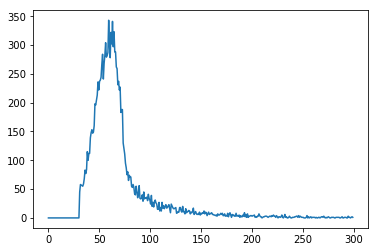

In [38]:
plt.plot(midpoints(ret["ggh"][0]["hist_subleading_jet_pt"].edges), ret["ggh"][0]["hist_subleading_jet_pt"].contents)
#plt.plot(midpoints(ret["hist_subleading_jet_pt"].edges), ret["hist_subleading_jet_pt"].contents)

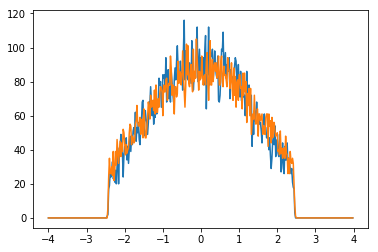

In [39]:
plt.plot(midpoints(ret["ggh"][0]["hist_mu0_eta"].edges), ret["ggh"][0]["hist_mu0_eta"].contents)
plt.plot(midpoints(ret["ggh"][0]["hist_mu1_eta"].edges), ret["ggh"][0]["hist_mu1_eta"].contents)